In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import RobustScaler
import hdbscan
import seaborn as sns

In [4]:
msel_data = pd.read_csv('behavioural_data/mullen_processed.csv')

msel_data = msel_data.set_index('subject')

msel_data.to_numpy().shape

(127, 5)

In [5]:
features = list(msel_data.columns)
subjects = list(msel_data.index)

scaled_msel = RobustScaler().fit_transform(msel_data.to_numpy())

scaled_msel = pd.DataFrame(scaled_msel, columns = features, index = subjects)

scaled_msel.index.name = 'subject'

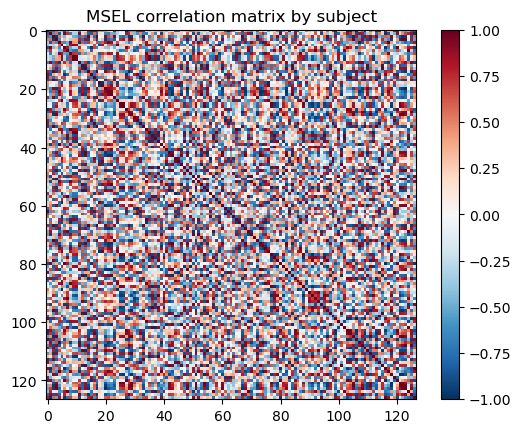

In [6]:
msel_corr = scaled_msel.transpose().corr(method = 'pearson')

plt.imshow(msel_corr, interpolation = 'nearest', cmap = "RdBu_r", vmin = -1, vmax = 1);
plt.title("MSEL correlation matrix by subject");
plt.colorbar();
plt.savefig("mullen_corr.png")

In [7]:
#add familial likelihood data to subject index
fl_df = pd.read_csv('familial_likelihood.csv')
msel_subs = scaled_msel.index.tolist()
fl_filtered = fl_df[fl_df['subject'].isin(msel_subs)]
fl_filtered = fl_filtered[fl_filtered['likelihood_group'].notnull()]
msel_filtered = scaled_msel[scaled_msel.index.isin(fl_filtered['subject'])]
fl_filtered = fl_filtered.set_index('subject')
df_joined = msel_filtered.merge(fl_filtered, on = 'subject')
df_joined.index = df_joined['likelihood_group'] + df_joined.index.astype(str)
df_joined = df_joined.drop(columns = ['likelihood_group'])
df_joined = df_joined.sort_index()

In [8]:
fl_filtered.astype('category').value_counts()

likelihood_group
autism              63
typical             24
ADHD                22
autism&ADHD         16
Name: count, dtype: int64

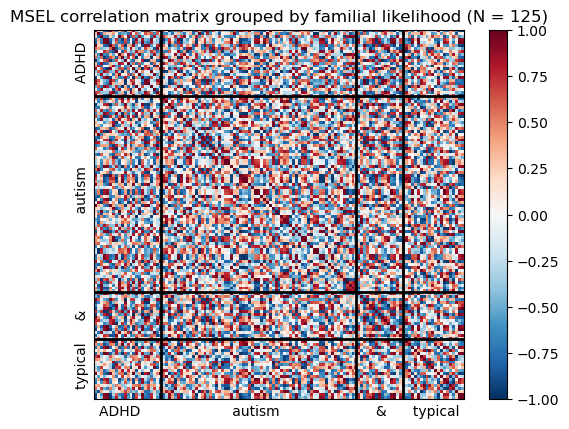

In [28]:
joined_sub_corr = df_joined.transpose().corr(method = 'pearson')

plt.imshow(joined_sub_corr, interpolation = 'nearest', cmap = "RdBu_r", vmin = -1, vmax = 1);
plt.title(f"MSEL correlation matrix grouped by familial likelihood (N = {joined_sub_corr.shape[0]})");
plt.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False);
plt.axhline(y = 22, color = "black", lw = 2);
plt.axhline(y = 88, color = "black", lw = 2);
plt.axhline(y = 104, color = "black", lw = 2);
plt.axvline(x = 22, color = "black", lw = 2);
plt.axvline(x = 88, color = "black", lw = 2);
plt.axvline(x = 104, color = "black", lw = 2);
plt.xlabel("ADHD                     autism                      &      typical");
plt.ylabel("typical     &                      autism                   ADHD");
plt.colorbar();
plt.savefig("combined_mullen_corr.png")

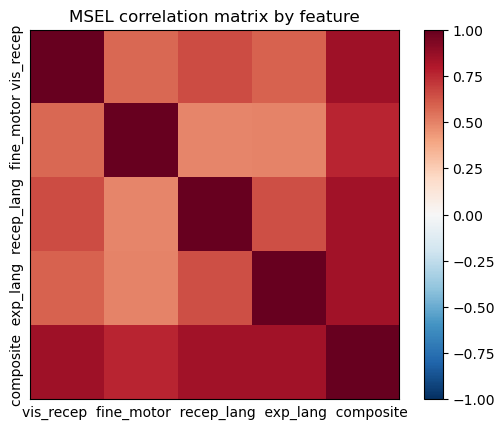

In [29]:
var_corr = df_joined.corr(method = 'pearson')

plt.imshow(var_corr, interpolation = 'nearest', cmap = "RdBu_r", vmin = -1, vmax = 1);
plt.title("MSEL correlation matrix by feature");
plt.colorbar();
plt.xlabel("vis_recep  fine_motor  recep_lang  exp_lang  composite");
plt.ylabel("composite  exp_lang  recep_lang  fine_motor vis_recep");
plt.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False);
plt.savefig("mullen_corr_var.png")

In [11]:
def label(group):
    if group == 'ADHD':
        return 1
    elif group == 'autism':
        return 2
    elif group == 'autism&ADHD':
        return 3
    elif group == 'typical':
        return 0
    else:
        return 7

In [12]:
msel_joined = scaled_msel.merge(fl_filtered, on = 'subject', how = 'outer').fillna(0)
msel_joined['fl_lab'] = msel_joined['likelihood_group'].apply(label)

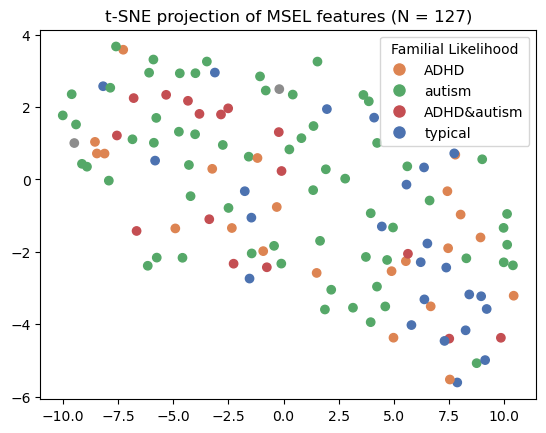

In [13]:
from matplotlib.lines import Line2D

tsne_projection = TSNE().fit_transform(scaled_msel.to_numpy())

color_palette = sns.color_palette('deep', 8)

colors = [color_palette[x] for x in msel_joined['fl_lab']]

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color_palette[1], markersize=10, label='ADHD'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor=color_palette[2], markersize=10, label='autism'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor=color_palette[3], markersize=10, label='ADHD&autism'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor=color_palette[0], markersize=10, label='typical')]

plt.scatter(*tsne_projection.T, c=colors);
plt.legend(handles = legend_elements, title='Familial Likelihood');
plt.title(f"t-SNE projection of MSEL features (N = {scaled_msel.shape[0]})");
plt.savefig("mullen_tsne_fl.png")

In [14]:
cluster_data = scaled_msel.to_numpy()

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True).fit(cluster_data)

clusterer1 = hdbscan.HDBSCAN(min_cluster_size=4, gen_min_span_tree=True).fit(cluster_data)

clusterer2 = hdbscan.HDBSCAN(min_cluster_size=3, gen_min_span_tree=True).fit(cluster_data)

clusterer3 = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True).fit(cluster_data)

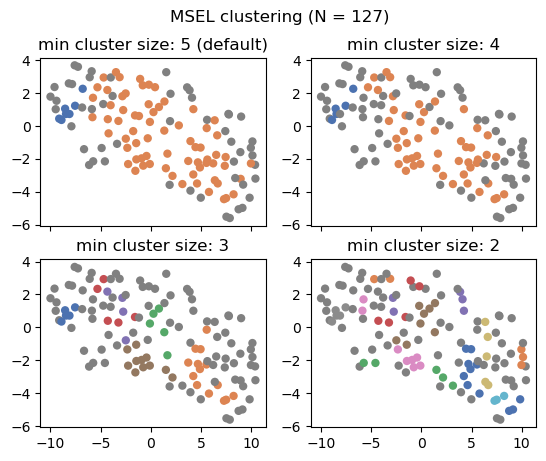

In [15]:
# specify color palette from seaborn
color_palette = sns.color_palette('deep', 20)

# plot1
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]

#plot2
cluster1_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer1.labels_]

#plot3
cluster2_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer2.labels_]

#plot4
cluster3_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer3.labels_]

# subplots for varying min cluster size parameter (2-5)
fig, axs = plt.subplots(2, 2, sharex = True)
axs[0,0].scatter(*tsne_projection.T, linewidth=0, c=cluster_colors)
axs[0,0].set_title('min cluster size: 5 (default)')
axs[0,1].scatter(*tsne_projection.T, linewidth=0, c=cluster1_colors)
axs[0,1].set_title('min cluster size: 4')
axs[1,0].scatter(*tsne_projection.T, linewidth=0, c=cluster2_colors)
axs[1,0].set_title('min cluster size: 3')
axs[1,1].scatter(*tsne_projection.T, linewidth=0, c=cluster3_colors)
axs[1,1].set_title('min cluster size: 2')
fig.suptitle(f'MSEL clustering (N = {cluster_data.shape[0]})');
fig.savefig("compare_hbdscan_mullen.png")

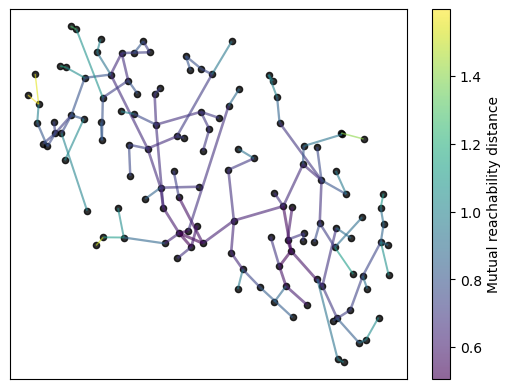

In [30]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=20,
                                      edge_linewidth=1);
plt.savefig('msel_mstree.png')

labels: [-1  0  1] 
 count: [51  7 69]


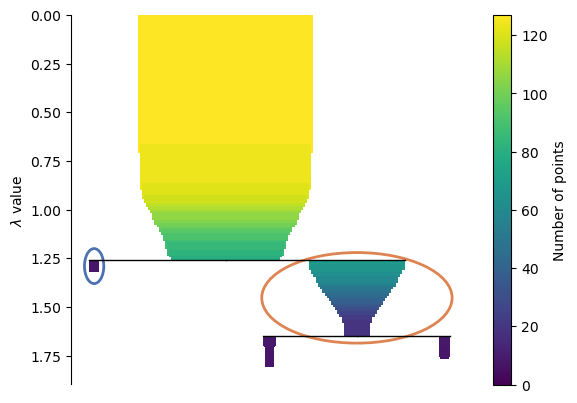

In [19]:
unique, frequency = np.unique(clusterer.labels_,
                              return_counts = True)

print(f'labels: {unique} \n count: {frequency}')


clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8));
plt.savefig('msel_ctree.png')

In [21]:
cluster_labs = pd.DataFrame(index=scaled_msel.index, data=list(clusterer.labels_), columns=['cluster_lab'])

cluster_labs['cluster_prob'] = list(clusterer.probabilities_)

cluster_labs.to_csv('msel_cluster.csv')

cluster_labs

,cluster_lab,cluster_prob
subject,,
3001,1,0.836608
3002,-1,0.000000
3003,0,1.000000
3004,1,0.834776
3005,1,1.000000
...,...,...
3161,-1,0.000000
3162,1,0.802188
3163,-1,0.000000
